<h1><span style='color:Blue'><u>Implémentation un modèle de scoring bancaire</u><br></span></h1>


# I. Contexte

Une société financière  propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
 
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).  

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.  

Elle a donc décidé de faire développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

Cette étude a pour but de:  
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.  
  
  
# II. Initialization


In [ ]:
##############################################################################

import gc
import time
import sys
import re
import pickle
import joblib

from IPython.core.debugger import set_trace
from IPython.display import Audio, display

import numpy as np
import pandas as pd
from scipy.stats import loguniform

# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from contextlib import contextmanager

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, auc
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost.sklearn import XGBClassifier   
from catboost import CatBoostClassifier

import shap
import category_encoders as ce

from my_ml_helper_functions_py import *


In [ ]:
def sep_func():
    """Display a separator line & the function name at the start 
          of a function
    """
    print(nl, 50*'-', sys._getframe().f_back.f_code.co_name, nl)
    #print(nl, 50*'-', sys._getframe().f_code.co_name, nl)
    
    
    
%matplotlib inline
sns.set_theme(context='paper') 
pd.set_option('display.max_columns', None)
np.set_printoptions(edgeitems=5, linewidth=120,
                    formatter={'float': '{: 0.3f}'.format})

warnings.simplefilter(action='ignore', category=FutureWarning)

        

In [ ]:
# GLOBAL CONSTANTS


PATH_DATA = '../input/home-credit-default-risk/'  
    # from https://www.kaggle.com/c/home-credit-default-risk/data

MERGED_FILE = '' #'../input/oc-p7-merged-data/merged_data_307509.csv'
    # use the path to the merged data to use or =='' for normal processing
    # need to create a dataset (click "+ Add data") to use the output .csv

SEED = 0
MODEL = 'CatBoost'  # 'CatBoost'/'LightGBM'/'XGBoost'/'LogisticR'/'Dummy'

# TRAIN_SIZE, TEST_SIZE = 1, 1   # to use if real run & not 'debug' mode
# For debug (quick run/test):
TRAIN_SIZE = int(10*5000/0.8)  #307509
TEST_SIZE = 1000 #1*100 + 0*int(TRAIN_SIZE / 307.511 * 48.744)


THRESHOLD1 = 0.165 #0.08   # for ROC, ...


FNFP = 10   # Coef. on FN in cost matrix (with FP=TN=1 anf TP=0)


SCAL = False  # True for StandardScaler or ...
IMPUT = False  # True if want to impute NaN (not needed for LGBM, XGBoost)
ENCOD = True  # True if want to transform categorical variables to numerical
CALIB = False  # True if want to calibrate the probability distribution


DUMMY = False   # True if use Dummy classifier or LogisticRegression


P_NAN = 0.3   # max. % of NaN per variable (1.0 to take all variables)

# Look at the top xx variables importance by taking all variables 
# (whatever NaN count) (not) in top 100: 
NAN_KEEP1 =['EXT_SOURCE_1', 'REFUSED_DAYS_DECISION_MAX', 
            'INSTAL_AMT_PAYMENT_MIN', 'POS_COUNT', 
            'CLOSED_AMT_CREDIT_SUM_DEBT_SUM', 
            #'APPROVED_CNT_PAYMENT_MEAN', #removed as correlated w/ next one
            'PREV_CNT_PAYMENT_MEAN', 'AMT_CREDIT'
]
# not in top 50 but in top 50-60: 
NAN_KEEP2 = ['APPROVED_APP_CREDIT_PERC_MEAN', 'CLOSED_AMT_CREDIT_SUM_MEAN', 
#              'CLOSED_AMT_CREDIT_SUM_MEAN', 'AMT_REQ_CREDIT_BUREAU_QRT', 
#              'INSTAL_PAYMENT_DIFF_MAX'
    ]
NAN_KEEP = NAN_KEEP1 + NAN_KEEP2


# Columns with a correlation (spearman)> 0.85 with another column
DROP_CORREL = [
    'ACTIVE_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_MAX',
    'PREV_CNT_PAYMENT_MEAN', 'INSTAL_DPD_MAX',
    'AMT_GOODS_PRICE', 'INSTAL_AMT_PAYMENT_SUM',
#     'AMT_ANNUITY', 'CLOSED_AMT_CREDIT_SUM_SUM', 
#     'INSTAL_PAYMENT_PERC_SUM', 'INSTAL_AMT_PAYMENT_SUM'
#     #'CODE_GENDER', 'DAYS_BIRTH',
    ]


# used for imputing = CAT_VAR0 + cat. var. created (like '..._MODE2')
CAT_VAR = []  
CAT_VAR0 = [  # list of all original categorical variables
        'NAME_CONTRACT_TYPE',
        'CODE_GENDER',
        'FLAG_OWN_CAR',
        'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE',
        'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE',
        'FLAG_MOBIL',
        'FLAG_EMP_PHONE',
        'FLAG_WORK_PHONE',
        'FLAG_CONT_MOBILE',
        'FLAG_PHONE',
        'FLAG_EMAIL',
        'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START',
        'HOUR_APPR_PROCESS_START',
        'REG_REGION_NOT_LIVE_REGION',
        'REG_REGION_NOT_WORK_REGION',
        'LIVE_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_LIVE_CITY',
        'REG_CITY_NOT_WORK_CITY',
        'LIVE_CITY_NOT_WORK_CITY',
        'ORGANIZATION_TYPE',
        'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE',
        'WALLSMATERIAL_MODE',
        'EMERGENCYSTATE_MODE',
        'FLAG_DOCUMENT_2',
        'FLAG_DOCUMENT_3',
        'FLAG_DOCUMENT_4',
        'FLAG_DOCUMENT_5',
        'FLAG_DOCUMENT_6',
        'FLAG_DOCUMENT_7',
        'FLAG_DOCUMENT_8',
        'FLAG_DOCUMENT_9',
        'FLAG_DOCUMENT_10',
        'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12',
        'FLAG_DOCUMENT_13',
        'FLAG_DOCUMENT_14',
        'FLAG_DOCUMENT_15',
        'FLAG_DOCUMENT_16',
        'FLAG_DOCUMENT_17',
        'FLAG_DOCUMENT_18',
        'FLAG_DOCUMENT_19',
        'FLAG_DOCUMENT_20',
        'FLAG_DOCUMENT_21',
        'CREDIT_ACTIVE',
        'CREDIT_CURRENCY',
        'CREDIT_TYPE',
        'STATUS',
        'NAME_CONTRACT_STATUS',
        'NAME_CONTRACT_STATUS',
        'NAME_CONTRACT_TYPE',
        'WEEKDAY_APPR_PROCESS_START',
        'HOUR_APPR_PROCESS_START',
        'FLAG_LAST_APPL_PER_CONTRACT',
        'NFLAG_LAST_APPL_IN_DAY',
        'NFLAG_MICRO_CASH',
        'NAME_CASH_LOAN_PURPOSE',
        'NAME_CONTRACT_STATUS',
        'NAME_PAYMENT_TYPE',
        'CODE_REJECT_REASON',
        'NAME_TYPE_SUITE',
        'NAME_CLIENT_TYPE',
        'NAME_GOODS_CATEGORY',
        'NAME_PORTFOLIO',
        'NAME_PRODUCT_TYPE',
        'CHANNEL_TYPE',
        'NAME_SELLER_INDUSTRY',
        'NAME_YIELD_GROUP',
        'PRODUCT_COMBINATION',
        'NFLAG_INSURED_ON_APPROVAL',
    ]


# Top variables from Shap Importance  
# top50 shap > top50 tree > top50 permut > top100 permut 
#    > top75 permut > top all
TOP50_VAR =  [   # no removing for nan
    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'CODE_GENDER', 
    'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'APPROVED_CNT_PAYMENT_MEAN', 
    'DAYS_EMPLOYED', 'PAYMENT_RATE', 'NAME_EDUCATION_TYPE', 'AMT_CREDIT', 
    'INSTAL_DPD_MEAN', 'FLAG_OWN_CAR', 'DAYS_BIRTH', 'NAME_FAMILY_STATUS', 
    'INSTAL_AMT_PAYMENT_SUM', 'DAYS_ID_PUBLISH', 'INSTAL_AMT_INSTALMENT_SUM',
    'APPROVED_APP_CREDIT_PERC_MAX', 'FLAG_DOCUMENT_3', 
    'INSTAL_PAYMENT_DIFF_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'ORGANIZATION_TYPE',
    'NAME_INCOME_TYPE', 'PREV_APP_CREDIT_PERC_MIN', 
    'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'ANNUITY_INCOME_PERC', 
    'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'PREV_NAME_YIELD_GROUP_MODE2', 
    'CLOSED_AMT_CREDIT_SUM_SUM', 'ACTIVE_AMT_CREDIT_SUM_SUM', 
    'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'POS_MONTHS_BALANCE_SIZE', 
    'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'ACTIVE_DAYS_CREDIT_MAX', 
    'INSTAL_DPD_MAX', 'ACTIVE_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_MAX', 
    'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'REGION_POPULATION_RELATIVE', 
    'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_PAYMENT_PERC_SUM', 
    'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_MEAN', 
    'PREV_NAME_GOODS_CATEGORY_MODE2', 'CLOSED_DAYS_CREDIT_MAX', 
    'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'APPROVED_AMT_GOODS_PRICE_MIN', 
    'POS_COUNT', 'BURO_DAYS_CREDIT_ENDDATE_MAX'
]
TOP50_VAR =  TOP50_VAR + ['TARGET']


In [ ]:
# Run this cell only when needed, to save time
# if not, uncomment last lines
   
        
# # Tool to determine the columns which have less than 30% of missing values: COL_SEL

# list_files = ['application_train.csv', 'bureau.csv', 
#               'bureau_balance.csv', 'previous_application.csv', 
#               'POS_CASH_balance.csv', 'installments_payments.csv',
#               'credit_card_balance.csv']
# COL_SEL = []  # columns read from the csv files

# for f in list_files:
#     df_f = pd.read_csv(PATH_DATA + f)
#     print('----', f)
#     mydisplay(df_f.head(5))
#     ser = df_f.isna().mean().sort_values(ascending=False)
#     # Remove variables with too many NaN (also done at the end of Main)
#     # mydisplay(ser[ser<0.30], gen_width=300)
#     COL_SEL.extend(ser[ser<P_NAN].index)

# NAN_KEEP = [col for col in NAN_KEEP if col not in COL_SEL]
# COL_SEL.extend(NAN_KEEP)
    
# print(COL_SEL)
# print('# Unique variables selected (less than 30% NaN):', len(set(COL_SEL)))
# # print(set(COL_SEL))



# If the above part is commented, use:
# For 30%: 141 variables out of 218 (same variables whatever train_size)
COL_SEL = ['FLAG_DOCUMENT_13', 'CREDIT_DAY_OVERDUE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'POS_COUNT', 'FLAG_DOCUMENT_16', 'LIVE_REGION_NOT_WORK_REGION', 'CNT_DRAWINGS_ATM_CURRENT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'DAYS_BIRTH', 'CNT_INSTALMENT_FUTURE', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_4', 'AMT_DRAWINGS_ATM_CURRENT', 'REG_CITY_NOT_WORK_CITY', 'SK_ID_PREV', 'CNT_CREDIT_PROLONG', 'NUM_INSTALMENT_NUMBER', 'DAYS_LAST_PHONE_CHANGE', 'AMT_CREDIT', 'FLAG_DOCUMENT_7', 'AMT_INSTALMENT', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_DOCUMENT_9', 'CHANNEL_TYPE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_WORK_PHONE', 'DAYS_ENTRY_PAYMENT', 'FLAG_PHONE', 'FLAG_OWN_CAR', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'CNT_DRAWINGS_POS_CURRENT', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'AMT_PAYMENT_TOTAL_CURRENT', 'NAME_FAMILY_STATUS', 'AMT_ANNUITY', 'FLAG_DOCUMENT_5', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_GOODS_CATEGORY', 'DAYS_EMPLOYED', 'FLAG_DOCUMENT_15', 'CNT_DRAWINGS_OTHER_CURRENT', 'SK_ID_BUREAU', 'NFLAG_LAST_APPL_IN_DAY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_INSTALMENT_MATURE_CUM', 'AMT_REQ_CREDIT_BUREAU_MON', 'DAYS_REGISTRATION', 'CLOSED_AMT_CREDIT_SUM_DEBT_SUM', 'FLAG_DOCUMENT_2', 'DAYS_DECISION', 'AMT_CREDIT_SUM_DEBT', 'STATUS', 'FLAG_OWN_REALTY', 'CODE_REJECT_REASON', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'INSTAL_AMT_PAYMENT_MIN', 'CNT_DRAWINGS_CURRENT', 'AMT_BALANCE', 'NUM_INSTALMENT_VERSION', 'REG_REGION_NOT_WORK_REGION', 'NAME_EDUCATION_TYPE', 'CNT_CHILDREN', 'AMT_PAYMENT', 'CODE_GENDER', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'FLAG_MOBIL', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'CREDIT_CURRENCY', 'REG_CITY_NOT_LIVE_CITY', 'AMT_CREDIT_SUM', 'REGION_POPULATION_RELATIVE', 'NAME_PORTFOLIO', 'FLAG_DOCUMENT_3', 'NAME_PRODUCT_TYPE', 'AMT_TOTAL_RECEIVABLE', 'EXT_SOURCE_1', 'FLAG_EMP_PHONE', 'CNT_INSTALMENT', 'ORGANIZATION_TYPE', 'APPROVED_APP_CREDIT_PERC_MEAN', 'AMT_CREDIT_SUM_OVERDUE', 'SELLERPLACE_AREA', 'NAME_YIELD_GROUP', 'PREV_CNT_PAYMENT_MEAN', 'SK_DPD', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_6', 'PRODUCT_COMBINATION', 'DEF_30_CNT_SOCIAL_CIRCLE', 'CNT_PAYMENT', 'FLAG_DOCUMENT_14', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_APPLICATION', 'REG_REGION_NOT_LIVE_REGION', 'AMT_PAYMENT_CURRENT', 'REGION_RATING_CLIENT', 'FLAG_EMAIL', 'REFUSED_DAYS_DECISION_MAX', 'FLAG_DOCUMENT_11', 'DAYS_CREDIT_UPDATE', 'AMT_INST_MIN_REGULARITY', 'AMT_DRAWINGS_CURRENT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'NAME_CONTRACT_TYPE', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_19', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_SELLER_INDUSTRY', 'REGION_RATING_CLIENT_W_CITY', 'FLAG_DOCUMENT_21', 'SK_DPD_DEF', 'NAME_CASH_LOAN_PURPOSE', 'CREDIT_ACTIVE', 'CREDIT_TYPE', 'FLAG_CONT_MOBILE', 'AMT_RECIVABLE', 'FLAG_DOCUMENT_18', 'APPROVED_CNT_PAYMENT_MEAN', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_DRAWINGS_OTHER_CURRENT', 'NAME_PAYMENT_TYPE', 'NAME_CONTRACT_STATUS', 'FLAG_DOCUMENT_8', 'SK_ID_CURR', 'NAME_CLIENT_TYPE', 'TARGET', 'DAYS_ID_PUBLISH', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT', 'NAME_HOUSING_TYPE', 'DAYS_INSTALMENT', 'NAME_TYPE_SUITE', 'EXT_SOURCE_3']
print(len(set(COL_SEL)), nl, set(COL_SEL))



## Organigram showing the merging of all the input files

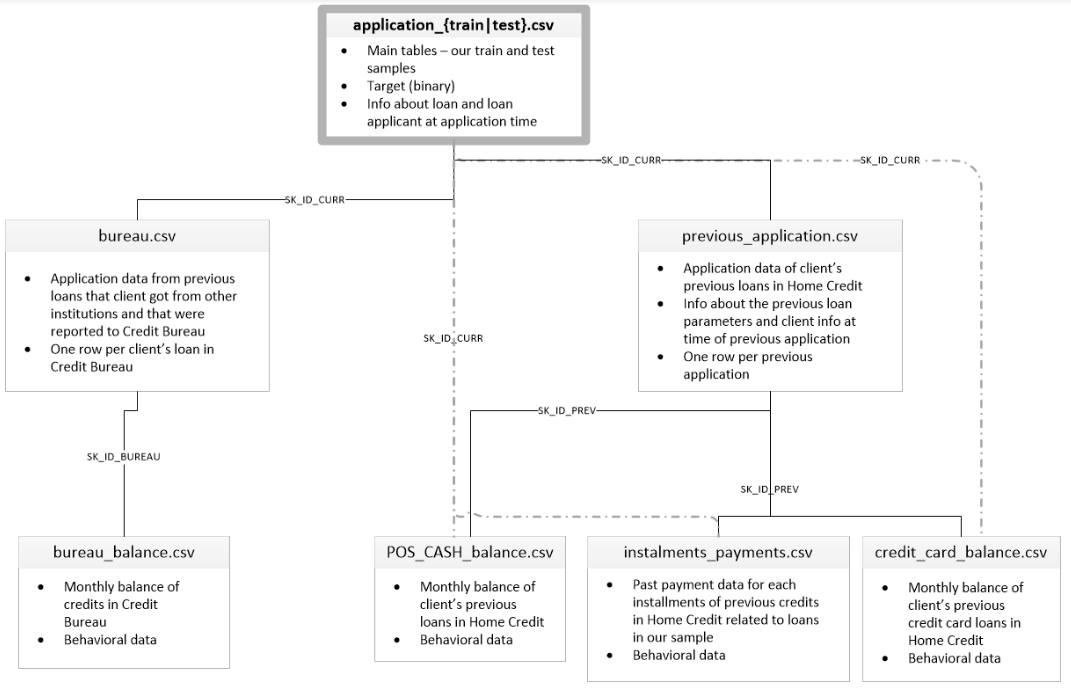

In [ ]:
"""
---Home Credit
Home Credit strives to broaden financial inclusion for the unbanked population 
by providing a positive and safe borrowing experience. In order to make sure this 
underserved population has a positive loan experience, Home Credit makes use of 
a variety of alternative data--including telco and transactional information--
to predict their clients' repayment abilities.

We primarily offer convenient and affordable point-of-sales (“POS”) loan, cash 
loan, and revolving loan products to underserved borrowers in nine countries 
(China, Kazakhstan, India, Indonesia, Vietnam, the Philippines, the Czech 
Republic and Slovakia)
Over our successful 22-year track record, we have accumulated a wealth of 
experience expanding our operations and navigating through credit cycles, while 
accumulating a large volume of borrower behaviour data which we use to refine 
risks and cross-selling.

---Credit Bureau
A credit bureau is a data collection agency that gathers account information 
from various creditors and provides that information to a consumer reporting 
agency in the United States.

A credit bureau, also known in the U.S. as a credit reporting agency, is an 
organization that collects and researches individual credit information and 
sells it to creditors for a fee, so they can make decisions about extending 
credit or granting loans.
The top three credit bureaus in the U.S. are Experian, Equifax, and TransUnion, 
although there are several others as well. Credit bureaus assign credit scores 
to individuals based on the credit history that they assemble.
Credit scores are important predictors of whether or not you will qualify for 
credit and on what terms. Credit bureaus do not decide whether or not you will 
get credit—they merely collect and synthesize information regarding your credit 
risk and give it to lending institutions.

"""


"""
Data Description

--- application_{train|test}.csv
This is the main table, broken into two files for Train (with TARGET) and 
Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

--- bureau.csv
All client's previous credits provided by other financial institutions that were 
reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the 
client had in Credit Bureau before the application date.

--- bureau_balance.csv
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported
to Credit Bureau – i.e the table has (#loans in sample * # of relative previous 
credits * # of months where we have some history observable for the previous 
credits) rows.

--- POS_CASH_balance.csv
Monthly balance snapshots of previous POS (point of sales) and cash loans that the 
applicant had with Home Credit. This table has one row for each month of history of 
every previous credit in Home Credit (consumer credit and cash loans) related to 
loans in our sample – i.e. the table has (#loans in sample * # of relative previous 
credits * # of months in which we have some history observable for the previous 
credits) rows.

--- credit_card_balance.csv
Monthly balance snapshots of previous credit cards that the applicant has with Home
Credit. This table has one row for each month of history of every previous credit 
in Home Credit (consumer credit and cash loans) related to loans in our sample – 
i.e. the table has (#loans in sample * # of relative previous credit cards * # of 
months where we have some history observable for the previous credit card) rows.

--- previous_application.csv
All previous applications for Home Credit loans of clients who have loans in our 
sample. There is one row for each previous application related to loans in our data 
sample.

--- installments_payments.csv
Repayment history for the previously disbursed credits in Home Credit related to 
the loans in our sample. There is a) one row for every payment that was made plus b) 
one row each for missed payment. One row is equivalent to one payment of one 
installment OR one installment corresponding to one payment of one previous Home 
Credit credit related to loans in our sample.

--- HomeCredit_columns_description.csv
This file contains descriptions for the columns in the various data files.


-----------------------------
Target variable (1 - client with payment difficulties: he/she had late payment more 
than X days on at least one of the first Y installments of the loan in our sample, 
0 - all other cases)


-----------------------------
- application_train 307 511, 122 (class1/class0=24825/(282686+24825)=8.1%)
- application_test 48 744, 121
- bureau 1 716 428, 17  (305 811 unic sk_id_curr)
- bureau_balance 27 299 925, 3  (817 395 unic sk_id_bureau)
- previous_application 1 670 214, 37  (338 857 unic sk_id_curr)
- pos_cash_balance 10 001 358, 8  (337 252 unic sk_id_curr, 936 325 unic sk_id_prev)
- installments_payment 13 605 401, 8  (339 587 unic sk_id_curr, 997 752 unic sk_id_prev)
- credi_card_balance 3 840 312, 23  (103 558 unic sk_id_curr, 104 307 unic sk_id_prev)

final df:  356 251, 798  (ie sum of train + 'test')

""";

# III. Preprocessing  

Encoding  
Imputing  
Scaling  
  

In [ ]:
    
def encoding(train_df, test_df, categorical_columns=[]):  
    """Encoding for categorical columns"""
    
    print(nl, 'Encoding categorical features ...')
    print('categ. var.:', nl, categorical_columns, nl)
    
    if len(categorical_columns)>0: 
        mydisplay(train_df[categorical_columns].head(10), 'train_df categ')
    
    encoder = ce.CountEncoder(cols=categorical_columns, 
                              handle_missing='return_nan')
#     encoder = ce.OneHotEncoder(cols=categorical_columns, 
#                                use_cat_names=True, 
#                                handle_unknown='indicator') 
    train_df = encoder.fit_transform(train_df) 
    test_df = encoder.transform(test_df)
    
    return train_df, test_df 



def imputing(train_df, test_df, cat=None):
    """Impute missing values
    Most frequent value for a categorical variable
    Mean value for a numerical variable"""
    
    # Need SimpleImputer against data leakage
    print(nl, 'Imputing missing data ...')
    num = [col for col in train_df.columns if col not in cat]
    
    imp_mean = SimpleImputer(strategy='mean')
    train_df[num] = imp_mean.fit_transform(train_df[num])
    test_df[num] = imp_mean.transform(test_df[num])
    
    imp_freq = SimpleImputer(strategy='most_frequent')
    train_df[cat] = imp_freq.fit_transform(train_df[cat])
    test_df[cat] = imp_freq.transform(test_df[cat])
    
    uni_miss(train_df)
    
    return train_df, test_df



def scaling(train_df, test_df):
    """Standard scaling of the variables"""
    
    print(nl, 'Scaling the data ...')
    num = [col for col in train_df.columns if col not in CAT_VAR]
    scaler = StandardScaler()  # RobustScaler()
    
    scaler.fit(train_df)
    train_df2 = scaler.transform(train_df)
    test_df2 = scaler.transform(test_df)
    train_df = pd.DataFrame(train_df2, columns=train_df.columns, 
                            index=train_df.index)
    test_df = pd.DataFrame(test_df2, columns=test_df.columns, 
                           index=test_df.index)
    
#     To scale only the numerical variables
#     scaler.fit(train_df[num])
#     train_df2 = scaler.transform(train_df[num])
#     test_df2 = scaler.transform(test_df[num])
#     train_df_num = pd.DataFrame(train_df2, columns=[num], 
#                             index=train_df.index)
#     test_df_num = pd.DataFrame(test_df2, columns=[num], 
#                            index=test_df.index)
#     train_df = pd.concat([train_df_num, train_df[CAT_VAR]], axis=1)
#     test_df = pd.concat([test_df_num, test_df[CAT_VAR]], axis=1)
    
    mydisplay(train_df.head(5))

    return train_df, test_df


# IV. Features engineering

In [ ]:
def application_train_test():
    """Load main data and preprocess application_train.csv 
       & application_test.csv"""
    
    sep_func()
    # Read data and merge
    df = pd.read_csv(PATH_DATA + 'application_train.csv')  
    df = df[[col for col in df.columns if col in COL_SEL]]

    # Select only some of the data for faster run
    df, _ = train_test_split(df, train_size=TRAIN_SIZE, random_state=SEED, 
                             stratify=df['TARGET'], shuffle=True)
    
    test_df = pd.read_csv(PATH_DATA + 'application_test.csv')
    test_df = test_df[[col for col in test_df.columns if col in COL_SEL]]
    test_df, _ = train_test_split(test_df, train_size=TEST_SIZE, 
                                  random_state=SEED)
    
    visudf(df, 'df') #; uni_miss(df)
    visudf(test_df, 'test_df') #; uni_miss(test_df)
    
    # Append test set below train set 
    # This a test set for kaggle scoring (no target provided) not a real test
    df = df.append(test_df).reset_index()
        
    # Remove 4 applications with XNA CODE_GENDER (train set)
    # df = df[df['CODE_GENDER'] != 'XNA']
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    del test_df
    gc.collect()
    
    return df 



def bureau_and_balance(idx = None):
    """Preprocess bureau.csv and bureau_balance.csv"""

    sep_func()
    bureau = pd.read_csv(PATH_DATA + 'bureau.csv')
    print('bureau shape:', bureau.shape)
    bureau = bureau[bureau['SK_ID_CURR'].isin(idx)]   
    bureau = bureau[[col for col in bureau.columns if col in COL_SEL]]
    visudf(bureau, 'bureau') 
    print('bureau shape:', bureau.shape)
    
    bb = pd.read_csv(PATH_DATA + 'bureau_balance.csv') 
    print('bb shape:', bb.shape)
    bb = bb[bb['SK_ID_BUREAU'].isin(bureau['SK_ID_BUREAU'])]
    bb= bb[[col for col in bb.columns if col in COL_SEL]]
    visudf(bb, 'bb') #; uni_miss(bb)
    print('bb shape:', bb.shape)
    print('idx[0:20]:', idx[0:20])
    
    bureau_cat = [col for col in bureau.columns if col in CAT_VAR0]
    bb_cat = [col for col in bb.columns if col in CAT_VAR0]
    print(bureau_cat, '---', bb_cat)
    visudf(bureau, 'bureau')
         
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = [mode2] 
        #[lambda x: x.value_counts().index[0][0]] #[pd.Series.mode] #['mean']
    print('bb_aggregations.items():', bb_aggregations.items())
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() 
                               for e in bb_agg.columns.tolist()])
    
    # Agregate bb to bureau vars after groupby sk_id_bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    mydisplay(bb_agg.head(50), 'bb_agg')
    
    print('bb_agg[STATUS_MODE2].unique():', bb_agg['STATUS_MODE2'].unique())
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
#         'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: 
        cat_aggregations[cat] = [mode2] #['mean']
    for cat in bb_cat: 
        cat_aggregations[cat + '_MODE2'] = [mode2] 
            #[lambda x: x.value_counts().index[0]] #
    print('num', num_aggregations.items())
    print('cat', cat_aggregations.items())
    print('col', bureau.columns)
    mydisplay(bureau.head(5), 'bureau')

    # Agregate now after group by on main key (sk_id_curr) on all num&cat
    # vars. Remove num_agg line below coz agg after with active/inactive? 
    # Do with cat like with num? if credit active have only active/closed 
    # in credit_active
#     bureau_agg = bureau.groupby('SK_ID_CURR').agg(cat_aggregations)
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, 
                                                   **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() 
                                   for e in bureau_agg.columns.tolist()])
    
    mydisplay(bureau_agg.head(5))
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() 
                                   for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() 
                                   for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    del closed, closed_agg, bureau
    gc.collect()
       
    return bureau_agg



def previous_applications(idx = None):
    """Preprocess previous_applications.csv"""

    sep_func()
    prev = pd.read_csv(PATH_DATA + 'previous_application.csv') 
    visudf(prev, 'prev') 
    prev = prev[[col for col in prev.columns if col in COL_SEL]]
    prev = prev[prev['SK_ID_CURR'].isin(idx)]
    cat_cols = [col for col in prev.columns if col in CAT_VAR0]
    
    # Days 365.243 values -> nan       # commented because >30% NaN
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, 
#                                               np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = np.where(
        prev['AMT_CREDIT']!=0, 
        prev['AMT_APPLICATION'] / prev['AMT_CREDIT'], 1e5)
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
#         'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
#         'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = [mode2] #['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, 
                                               **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() 
                                 for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() 
                                     for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() 
                                    for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg



def pos_cash(idx = None):
    """Preprocess POS_CASH_balance.csv"""

    sep_func()
    pos = pd.read_csv(PATH_DATA + 'POS_CASH_balance.csv') 
    visudf(pos, 'pos') 
    pos = pos[[col for col in pos.columns if col in COL_SEL]]
    pos = pos[pos['SK_ID_CURR'].isin(idx)]    
    cat_cols = [col for col in pos.columns if col in CAT_VAR0]
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = [mode2] #['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() 
                                for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    
    return pos_agg
    
    
    
def installments_payments(idx = None):
    """Preprocess installments_payments.csv"""
    
    sep_func()
    ins = pd.read_csv(PATH_DATA + 'installments_payments.csv') 
    visudf(ins, 'ins') 
    ins = ins[[col for col in ins.columns if col in COL_SEL]]
    ins = ins[ins['SK_ID_CURR'].isin(idx)]    
    cat_cols = [col for col in ins.columns if col in CAT_VAR0]
    
    # Percentage and difference paid in each installment 
    #  (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    for cat in cat_cols:
        aggregations[cat] = [mode2] #['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() 
                                for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
       
    return ins_agg



def credit_card_balance(idx = None):
    """Preprocess credit_card_balance.csv"""

    sep_func()
    cc = pd.read_csv(PATH_DATA + 'credit_card_balance.csv') 
    visudf(cc, 'cc') 
    cc = cc[[col for col in cc.columns if col in COL_SEL]]
    cc = cc[cc['SK_ID_CURR'].isin(idx)]    
    cat_cols = [col for col in cc.columns if col in CAT_VAR0]
    
    # General aggregations 
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 
                                           'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() 
                               for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
     
    return cc_agg



# V. Scores definition


In [ ]:
# Custom scoring functions

def my_cost_function(fn, fp, tn, tp):
    return (- FNFP*fn - 1*fp + 1*tn + 0*tp) / (fn + fp + tn + tp)

def f1_sc(y_true, p_pred, threshold=THRESHOLD1):
    y_pred = np.where(p_pred < threshold, 0, 1)
    return 'f1', f1_score(y_true, y_pred), True #higher is better

def auc_sc(y_true, y_pred):
    #y_pred = np.where(p_pred < THRESHOLD1, 0, 1)
    return 'auc2', roc_auc_score(y_true, y_pred), True #higher is better

def f3_sc(y_true, p_pred, threshold=THRESHOLD1):
    y_pred = np.where(p_pred < threshold, 0, 1)
    return 'f3', fbeta_score(y_true, y_pred, beta=3), True #higher is better
        # used in early stopping
    
def f3_sc2(y_true, p_pred, threshold=THRESHOLD1):   
    y_pred = np.where(p_pred < threshold, 0, 1)
    return fbeta_score(y_true, y_pred, beta=3)
        # formatted for use in make_scorer

def bus_sc(y_true, p_pred, threshold=THRESHOLD1):   
    """business cost function"""
    y_pred = np.where(p_pred < threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 'bus', my_cost_function(fn, fp, tn, tp), True #higher is better

def bus_sc2(y_true, p_pred, threshold=THRESHOLD1):   
    y_pred = np.where(p_pred < threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return my_cost_function(fn, fp, tn, tp)
        # formatted for use in make_scorer


f3_scorer = make_scorer(f3_sc2, greater_is_better=True, needs_proba=True)
    # Used in gridsearch & permutation importance & learning curve
    # et indirectement dans le choix du meilleur threshold        

bus_scorer = make_scorer(bus_sc2, greater_is_better=True, needs_proba=True)
    # Cannot be used as a custom loss function in lgbm/catboost as not 
    # differentiable and would need to provide 1st and 2nd order derivatives
    
                        
def mode2(col0):
    """Get the most common element in a column having NaN"""
    var = [x for x in col0 if x==x]  # remove NaN
    var = np.nan if (len(var)==0) else col0.value_counts().index[0]#[0]
    return var 


# VI. Display the results

In [ ]:
def print_scores(train_preds, Y_df, threshold=THRESHOLD1, title=''):
    """Print the main scores for a given data set"""
    
    train_class = np.where(train_preds < threshold, 0, 1)
    print(nl, title)
    print('*** AUC score %.3f' % roc_auc_score(Y_df,train_preds))   
    print('*** F1 score %.3f' % f1_score(Y_df, train_class))   
    print('*** F3 score %.3f' % fbeta_score(Y_df, train_class, beta=3)) 
    bus_min = my_cost_function(0.081, 1-0.081, 0, 0)  # = fn, fp, tn, tp
    bus_max = my_cost_function(0, 0, 1-0.081, 0.081)
    x_bus = bus_sc2(Y_df, train_preds, threshold)
    print('*** Bus. score %.3f' % x_bus)  
    print('      ratio =', round((x_bus - bus_min)/(bus_max - bus_min), 3),
          ' ( min / max =', bus_min, '/', bus_max, ')')
    print(nl)


def plot_results(Y_df, oof_preds, real_test_Y_df, real_test_preds):
    """Plot different results:
        - calibration curves
        - precision/recall curve
        - ROC
        - precision, recall and F3 by threshold
        - custom score by threshold
    It returns df_pr and df_pr_bus which are used by show_confusion_matrix()
    """
    
    # Probability calibration curves
    fop, mpv = calibration_curve(Y_df, oof_preds, n_bins=20) # normalize=True 
    plt.plot([0, 1], [0, 1], linestyle='--')   # plot perfectly calibrated 
    plt.plot(mpv, fop, marker='.')  
    plt.title('Calibration curve')
    plt.show()
    
    counts, edges, bars = plt.hist(oof_preds, bins=20)
    plt.bar_label(bars)
    plt.title('y_proba')
    plt.show()

    
    # Precision/Recall curve
    precision, recall, thresholds = precision_recall_curve(Y_df, oof_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(recall[:-1], precision[:-1], color='purple', marker='.') 
        #why one 'nan' in last position
    no_skill = len(Y_df[Y_df==1]) / len(Y_df)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()
    print('PR AUC score:', round(auc(recall, precision), 5))
    print('PR APS score:', 
          round(average_precision_score(Y_df, oof_preds), 5), 
          nl
    )
        
    # ROC curve
    fpr, tpr, thresholds_roc = roc_curve(Y_df, oof_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, color='purple', marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    ax.set_title('ROC Curve')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    plt.show()
    print('AUC score:', round(roc_auc_score(Y_df, oof_preds), 3), nl*2)

    
    # Plot the different scores according to threshold 
    fb, fb_cost, fb_x2 = [], [], []
    test_fb, test_fb_cost = [], [] 
    fb_x = np.linspace(0, 1, 201) #201 -> 1/(201-1)=0.005 intervals

    for i, thresh in enumerate(fb_x):
        if (thresh>0.2 and i%5): continue  # to speed-up plots
        t_class = np.where(oof_preds < thresh, 0, 1)
        test_t_class = np.where(real_test_preds < thresh, 0, 1)
        
        fb_x2.append(thresh)
        fb.append(fbeta_score(Y_df, t_class, beta=3))
        test_fb.append(fbeta_score(real_test_Y_df, test_t_class, beta=3))
        
        tn, fp, fn, tp = confusion_matrix(
            Y_df, t_class).ravel()
        test_tn, test_fp, test_fn, test_tp = confusion_matrix(
            real_test_Y_df, test_t_class).ravel()
        
        fb_cost.append(my_cost_function(fn, fp, tn, tp))
        test_fb_cost.append(my_cost_function(test_fn, test_fp, 
                                             test_tn, test_tp))

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(thresholds, precision[:-1], color='purple', marker='.', 
            label='Precision')
    ax.plot(thresholds, recall[:-1], color='blue', marker='.', 
            label='Recall')
    ax.plot(fb_x2, fb, color='green', marker='.', 
            label='F3')
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()
    print('Max F3: (', round(max(fb), 3), ') -',
          max(zip(fb_x2, fb), key = lambda x: x[1])[0], nl)
    
    
    # Plot custom score (train set)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fb_x2, fb_cost, color='purple', marker='.')
    plt.title('Custom Score vs Threshold (train set)')
    plt.show()
    print('Max Cust. Score: (', round(max(fb_cost), 4), ') -',
          max(zip(fb_x2, fb_cost), key = lambda x: x[1])[0], nl)
    
    
    # Plot custom score (test set)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fb_x2, test_fb_cost, color='purple', marker='.')
    plt.title('Custom Score vs Threshold (test set)')
    plt.show()
    print('Max Cust. Score: (', round(max(test_fb_cost), 4), ') -',
          max(zip(fb_x2, test_fb_cost), key = lambda x: x[1])[0], nl)
    
    
    #  Display scores 
    df_pr = pd.DataFrame([fb_x2, fb]).T
    df_pr.columns = ['thresholds', 'F3']
    mydisplay(df_pr.head(30), dig=3)

    df_pr_bus = pd.DataFrame([fb_x2, fb_cost]).T
    df_pr_bus.columns = ['thresholds', 'Cust. Cost']
    mydisplay(df_pr_bus.head(30), dig=3)
    
    df_pr2 = pd.DataFrame([precision, recall, thresholds]).T
    df_pr2.columns = ['precision', 'recall', 'thresholds']
    mydisplay(df_pr2.head(10)) ; mydisplay(df_pr2.tail(10))
    

#     # Learning curves
#     train_sizes, train_scores, test_scores, fit_times, score_times = \
#         learning_curve(clf, train_df, Y_df, cv=3,return_times=True, 
#                        scoring=f3_scorer, verbose=2, n_jobs=-1,
#                        train_sizes=np.linspace(0.1, 1.0, 5))
#     plt.plot(train_sizes,np.mean(train_scores,axis=1), label='Train score')
#     plt.plot(train_sizes,np.mean(test_scores,axis=1), label='Test score')
#     plt.title('Learning curves')
#     plt.show()
    
    return df_pr, df_pr_bus
    
    
    
def show_confusion_matrix(Y_df, oof_preds, threshold, title):
    """Display several:
        - confusion matrix
        - classification report
    """
    
    # Confusion matrix
    #    TN FP   (0,0)  (0,1)
    #    FN TP   (1,0)  (1,1)
    # Positive = defaulted so we want to avoid FN ie predicted negative 
    # but is positive

    print(nl*2, title, threshold)
    oof_class = np.where(oof_preds < threshold, 0, 1)
    conf_mat = confusion_matrix(Y_df, oof_class)
    conf_mat2 = confusion_matrix(Y_df, oof_class, normalize='true') 
                                 # true/pred/all/none
    print('Confusion matrix:') 
    for mat in [conf_mat, conf_mat2]:
        df_cm = pd.DataFrame(
            mat, 
            index = ['true ' + str(i) for i in range(2)],
            columns = ['pred ' + str(i) for i in range(2)])
        plt.figure(figsize = (6,4))
        sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
        plt.show() ; print(nl)
      
    # Classification report & Heatmap
    print('Classification report:', nl,
          classification_report(Y_df, oof_class), nl)
    
    # Scores
    print_scores(oof_preds, Y_df, threshold, '')
        


In [ ]:
def display_results(oof_preds, train_df, real_test_df, 
                    Y_df, real_test_Y_df, clf):
    """Print and plot the different results"""

    
    feats = [f for f in train_df.columns if f not in 
             ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    # Print the scores
    oof_class = np.where(oof_preds < THRESHOLD1, 0, 1)
    print('oof_preds, oof_class, Y_df:', nl, oof_preds[:20], nl, 
           oof_class[:20], nl, pd.DataFrame(Y_df[:20]).T, nl)
    print('resp. shapes:', oof_preds.shape, oof_class.shape, Y_df.shape, nl)
    print('Proba min/max:', nl, 
          round(oof_preds.min(), 5), round(oof_preds.max(), 5), nl)
    
    # train score
    print('Scores for the threshold', THRESHOLD1, nl)
    if CALIB or DUMMY:
        train_preds = clf_cc.predict_proba(train_df)[:, 1] 
    else:
        #train_preds = clf.predict_proba(train_df, 
        #                         num_iteration=clf_cc.best_iteration_)[:, 1]
        train_preds = clf.predict_proba(train_df)[:, 1]
    print_scores(train_preds, Y_df, THRESHOLD1, '**** Train set')
    
    # validation score
    print_scores(oof_preds, Y_df, THRESHOLD1, '**** Validation set')
    
    # test score
    if CALIB or DUMMY:
        real_test_preds = clf_cc.predict_proba(real_test_df[feats])[:, 1] 
    else:
        #train_preds = clf.predict_proba(real_test_df, 
        #                         num_iteration=clf_cc.best_iteration_)[:, 1]
        real_test_preds = clf.predict_proba(real_test_df[feats])[:, 1]
    print_scores(real_test_preds, real_test_Y_df, THRESHOLD1, '**** Test set')     
    
    # Plot the results
    df_pr, df_pr_bus = plot_results(Y_df, oof_preds, 
                                    real_test_Y_df, real_test_preds)

    # Display the confusion matrix & classification report
    show_confusion_matrix(
        Y_df, oof_preds, 
        threshold=THRESHOLD1, 
        title='------ For threshold =')
    show_confusion_matrix(
        Y_df, oof_preds, 
        threshold=df_pr.iloc[df_pr.idxmax()['F3']]['thresholds'], 
        title='------ Max. F3 - For threshold =')
    show_confusion_matrix(
        Y_df, oof_preds, 
        threshold=df_pr_bus.iloc[df_pr_bus.idxmax()['Cust. Cost']]['thresholds'], 
        title='------ Max. Custom Cost - For threshold =')
    
    

# VII. Features Importances   

Tree-based coefficients  
Permutation coefficients  
SHAP coefficients  


In [ ]:
def display_importances(feature_importance_df_, model, train_df, Y_df, 
                        test_df, real_test_df):
    """Display plots for:
        - tree-based feature importance
        - permutation-based feature importance
        - SHAP-based feature importance
        - several local SHAP plots
    Returns global ordered SHAP feature importance
    """
    
    sep_func()
    n_feats = 100
    
     # Tree-based feature importance
    print(nl, '*** Tree-based feature importance')
    cols = feature_importance_df_[["feature", "importance"]]   \
               .groupby("feature").mean()                     \
               .sort_values(by="importance", ascending=False)[:n_feats].index
                # average on all folds
    best_features = feature_importance_df_.loc[
                        feature_importance_df_['feature'].isin(cols)].copy()
    print('cols[:n_feats], best_features[:n_feats]:', 
          cols[:n_feats], best_features[:n_feats])
    
    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="feature",
                data=best_features.sort_values(by="importance", 
                                               ascending=False))
    plt.title('Impurity based Features (avg over oof folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances01.png')
    
    mydisplay(feature_importance_df_[["feature", "importance"]]   \
                  .groupby("feature").mean()                      \
                  .sort_values(by="importance", ascending=False).head(50))
    
    
    # Permutation importance
    print(nl, '*** Permutation importance')
    print('train_df & Y_df shape:', train_df.shape, Y_df.shape)
    print('train_df.isna().sum().sum():', train_df.isna().sum().sum())
    with timer("Permutation Importance"):
        result = permutation_importance(model, train_df, Y_df, n_jobs=-1, 
                                        scoring=f3_scorer, n_repeats=4, #25
                                        random_state=SEED  # don't use?
        ) 
    print('result.importances_mean:', result.importances_mean)
    sorted_idx = result.importances_mean.argsort()[-n_feats:]
    print(nl, 'sorted_idx:', sorted_idx)
    print('train_df & Y_df len:', len(train_df), len(Y_df),nl)
    print('train_df.columns[sorted_idx][::-1]:', 
          train_df.columns[sorted_idx][::-1]) 
    print('result.importances_mean[sorted_idx][::-1]:',
          result.importances_mean[sorted_idx][::-1])
    
    fig, ax = plt.subplots(figsize=(10,15))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, 
               labels=train_df.columns[sorted_idx]) 
    ax.set_title("Permutation Importances (oof of train set)")
    fig.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances02.png')
    
    
    
    # SHAP
    print('SHAP values (oof on train set):')    
#     model = model.calibrated_classifiers_[0].base_estimator
#         but it doesn't use the calibrated proba!
    explainer = shap.explainers.Tree(model, 
                                     seed=SEED,
#                                      model_output='probability', 
#                                         #'probability', 'log_loss', 'raw'
#                                      data=shap.maskers.Independent(
#                                              train_df, max_samples=1000)
                                    )
    # KernelExplainer a l'air de mieux marcher car accepte un modele 
    #    OU une fonction contrairement à 
    #    explainer.Tree mais très très lent: 2' pour 30 lignes!
#     explainer = shap.KernelExplainer(model.predict_proba, 
#                                      model_output='probability', 
#                                         #'probability', 'log_loss', 'raw'
#                                      data=train_df.loc[:30] 
#                                           #shap.maskers.Independent(
#                                           #   train_df, max_samples=1000)
#                                     )
    print(explainer.expected_value)
    print(explainer) 
    feats = [f for f in real_test_df.columns if f not in 
             ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    real_test_df = real_test_df[feats]
    shap_values = explainer.shap_values(real_test_df) #[1] #.loc[:1000])
        # [1] needed for LightGBM but not for XGBoost/CatBoost/...
    print(shap_values)
    
    # Summary plots (best global variables)  # better use real_test?
    shap.summary_plot(shap_values, real_test_df, plot_type="bar")#,show=False)  
        # bar, dot or violin  #show=False
    # plt.savefig('shap_global_importance.png')  # need show=False
    
    # Waterfall global
    shap.summary_plot(shap_values, real_test_df, plot_size=(20,8), show=False)   
    plt.gcf().axes[-1].set_aspect(100)  # to display correctly the color bar
    plt.gcf().axes[-1].set_box_aspect(100)  
    plt.savefig('shap_global_importance_wf.png')  # need show=False
    print('df.columns len:', len(real_test_df.columns))
    
    # Dependence plot
    fig, ax = plt.subplots(figsize=(15,8))
    shap.dependence_plot('EXT_SOURCE_3', shap_values, real_test_df, 
                         ax=ax, alpha=0.4) 
#     shap.dependence_plot("rank(1)", shap_values, X, 
#                         interaction_index="Education-Num")
    ax.set_aspect(300) ;  ax.set_box_aspect(300)  
        # to display correctly the color bar
    plt.show()
    
    # Waterfall shap (local)
#     explainer = shap.Explainer(model, seed=SEED)
#     print(explainer.expected_value)  
#     shap_values2 = explainer(model, data=shap.maskers.Independent(
#                                           train_df, max_samples=1000))
#     print(shap_values,)
#     ptint('shap_values.shape:', shap_values.shape)#.expected_value)  
#     shap.plots.waterfall(shap_values[1], max_display=15)
    
    # compute SHAP values
    #   Only model_output="raw" is supported for feature_perturbation=
    #    "tree_path_dependent"
    #   When do 'data' passed, it assumed feature_perturbation=
    #    "tree_path_dependent”
#     explainer2 = shap.Explainer(model, train_df) 
#     explainer = shap.explainers.Tree(model, 
# #                                      model_output='probability', 
#                                           #'probability', 'log_loss', 'raw'
# #                                      data=shap.maskers.Independent(
# #                                              train_df, max_samples=1000)   
#                                                # too slow if LightGBM
#                                     )
#     explainer = shap.Explainers(model.predict, model_output='probability', 
#                                        #'probability', 'log_loss', 'raw'
#                                      data=shap.maskers.Independent(
#                                            train_df, max_samples=1000))
#     shap.TreeExplainer(model)
#     print(explainer.expected_value) 

    exp_shap_values = explainer(real_test_df) #.loc[:1000])
    print('exp_shap_values.shape:', exp_shap_values.shape)
    #XGBoost, ...
    shap.plots.waterfall(exp_shap_values[1], max_display=15)
    shap.plots.waterfall(exp_shap_values[10], max_display=15)
#     #LGBM
#     shap.plots.waterfall(exp_shap_values[1, :, 1], max_display=15)
#     shap.plots.waterfall(exp_shap_values[10, :, 1], max_display=15)
    
    
    # Global shap importances
    feature_names = exp_shap_values.feature_names
    shap_df = pd.DataFrame(exp_shap_values.values, 
                           columns=feature_names)   # if not lgbm
#     shap_df = pd.DataFrame(exp_shap_values[:, :, 1].values, 
#                            columns=feature_names)   # if lgbm
#     print(exp_shap_values, exp_shap_values[:, :, 1].shape, 
#           len(feature_names))
    display(shap_df.head(5), 'shap_df')
    vals = np.round(np.abs(shap_df.values).mean(axis=0), 6)
    print('vals, round(vals[0], 6):', vals, round(vals[0], 6))
    shap_importance = pd.DataFrame(list(zip(feature_names, vals)), 
                                   columns=['col_name', 
                                            'feature_importance_vals'])
    #display(shap_importance.head())
    best_shap = shap_importance.sort_values(by=['feature_importance_vals'], 
                                        ascending=False) #, inplace=True))
    mydisplay(best_shap.head(), 'shap_importance')
    print('Top50:', best_shap['col_name'][:50].to_list())

    # SHAP values to 'pickle' for use in the app
    shap_to_pickle = (explainer.shap_values(test_df),
                      explainer(test_df)#,
                      #explainer.shap_values(real_test_df),
    )
    
    return shap_importance, shap_to_pickle

    
    
    
def distribution_plots(train_df, Y_df, shap_importance):
    """Display plots for:
        - univariate distribution plots separating both classes
        - bi-variate plot
    """
    
    full_train = pd.concat([train_df, Y_df], axis=1)
    
#    # Distribution plots   
        
#     for var in ['CODE_GENDER', 'FLAG_DOCUMENT_3']: 
                 #shap_importance['col_name'][:5]: 
#         g = sns.displot(data=full_train, x=var, hue='TARGET', bins=20, 
#                         stat="density", common_norm=False)
#         val_cust = full_train.iloc[0][var]
#         g.fig.axes[0].axvline(x=val_cust, color='g', ls='--', label='cust')
#         plt.show() 
#     print('***')

    # histogram
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))
    axs = axs.ravel()
    for i, var in enumerate(train_df.columns[:12]):
        g = sns.histplot(data=full_train, x=var, hue='TARGET', bins=20, 
                        ax=axs[i], stat="density", common_norm=False)
        val_cust = full_train.iloc[0][var]
        #g.fig.axes[0].axvline(x=val_cust, color='g', ls='--', label='cust')
        g.axes.axvline(x=val_cust, color='g', ls='--', label='cust')
        plt.tight_layout()
    plt.show() 
    print(nl, '***', nl)
    
    # kde line
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))
    axs = axs.ravel()
    for i, var in enumerate(train_df.columns[:12]): 
        g = sns.kdeplot(data=full_train, x=var, hue='TARGET', 
                        ax=axs[i], common_norm=False)
        val_cust = full_train.iloc[0][var]
        g.axvline(x=val_cust, color='g', ls='--', label='cust')
    plt.tight_layout()
    plt.show() 
    print(nl, '***', nl)    
    
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))
    axs = axs.ravel()
    for i, var in enumerate(shap_importance['col_name'][:12]): 
        g = sns.kdeplot(data=full_train, x=var, hue='TARGET', ax=axs[i],
                        common_norm=False)
        val_cust = full_train.iloc[0][var]
        g.axvline(x=val_cust, color='g', ls='--', label='cust')
    plt.tight_layout()
    plt.show() 
    print(nl, '***', nl)    
    
    
    # Bivariate plot (scatter)  
    g = sns.jointplot(x=full_train['EXT_SOURCE_3'], 
                      y=full_train['EXT_SOURCE_2'],
                      hue=full_train['TARGET'], palette='Set1', #kind="kde"
                      marker="s", s=20, height=8, 
                      ratio=8) #ratio = joint plot size / marginal plot size
    g.ax_joint.scatter(x=full_train.iloc[5]['EXT_SOURCE_3'], marker='o',   
                       y=full_train.iloc[5]['EXT_SOURCE_2'], color='g', s=200)
    g.ax_joint.set_xlim(-0.01, 1.0) ; g.ax_joint.set_ylim(-0.01, 1.0)
    plt.show()
    
    # With jointgrid to have normalized kde marginal plots
    g = sns.JointGrid(data=full_train, x='EXT_SOURCE_3', y='EXT_SOURCE_2', 
                      hue='TARGET', palette='Set1', #kind="kde"
                      height=8, ratio=8, xlim=(-0.01,1.0), ylim=(-0.01,1.0))
    g.plot_joint(sns.scatterplot, marker="s", s=20)
    g.plot_marginals(sns.kdeplot, common_norm=False)     
    g.ax_joint.scatter(x=full_train.iloc[5]['EXT_SOURCE_3'], marker='o',   
                       y=full_train.iloc[5]['EXT_SOURCE_2'], color='g', s=200)
    plt.show()


# VIII. ML models

In [ ]:
def kfold_algo(data_df, num_folds, stratified = True):
    """Run ML algo on Stratified KFold"""    

    sep_func()
    train_df, Y_df, real_test_df, real_test_Y_df, test_df = data_df
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, 
                                shuffle=True, random_state=SEED)
    else:
        folds = KFold(n_splits= num_folds, 
                      shuffle=True, random_state=SEED)
    
    oof_preds = np.zeros(train_df.shape[0])  # validation folds
    sub_preds = np.zeros(test_df.shape[0])   # Kaggle submission 
    test_preds = np.zeros(real_test_df.shape[0])   # real test set
    feature_importance_df = pd.DataFrame()
    # feats are the variables used for fitting the model
    feats = [f for f in train_df.columns if f not in 
             ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    print('len(feats):', len(feats)) 
    

    if MODEL == 'LightGBM':
        clf = LGBMClassifier(
                   colsample_bytree=0.64,
                   learning_rate=0.048987, max_depth=3,
                   metric=['binary_logloss', 'auc'], n_estimators=850,
                   random_state=SEED, subsample=0.76,
                   n_jobs=-1, 
                   device = 'gpu'
        )
        clf_param = {'learning_rate': loguniform(0.0001, 0.1), 
                         #np.geomspace(0.001, 0.1, num=1000000), 
                     'max_depth': np.arange(3,8,1),  
                     'subsample': np.arange(0.00,0.99,0.01),   
                         # n=(max-min)/delta+1
                     'colsample_bytree': np.arange(0.00,0.99,0.01), 
                     'n_estimators': np.arange(100,500,1)
        }

    elif MODEL == 'XGBoost':
        CALIB = True
        clf = XGBClassifier(n_estimators=330, max_depth=6 , 
                            colsample_bytree=0.70, 
                            subsample=0.69, learning_rate=0.033013, 
    #                         tree_method = 'hist', 
    #                         single_precision_histogram=True, 
                            n_jobs=-1, random_state=SEED,
                            tree_method = 'hist', #'gpu_hist', #speedup on gpu
                            single_precision_histogram=True, #fspeedup on gpu
    #                         scale_pos_weight=1/0.08,  
    #                            #nb lass0/nb class1 ie 1/0.088
        )
        clf_param = {'learning_rate': np.geomspace(0.1, 0.001, num=1000000), 
                     'max_depth': np.arange(3,8,1),  
                     'subsample': np.arange(0.00,0.99,0.01),   
                         # n=(max-min)/delta+1
                     'colsample_bytree': np.arange(0.00,0.99,0.01), 
                     'n_estimators': np.arange(20,200,1)
        }  #surtout n_estim et learning rate
        # To speed up: 
        # - if GPU: tree_method = 'gpu_hist', 
        #           single_precision_histogram=True,n_jobs=-1
        # - 'hist' if no GPU (but still x30 faster than w/o) 
        # LR et Iter sont liés donc fix les autres variables à valeurs 
        # du last best model & randomsearch only LR et Iter
        # It seems that n_estimators (term not used ib xgboost doc, nb of trees)
        # would be num_parallel_tree 
        # (1 tree by default for each iter. * num_rounds(nb iter.)

    elif MODEL == 'CatBoost':
        # If let CatBoost deals with the categorical variables, need to replace 
        # nan by a string like 'nan'
        clf = CatBoostClassifier(thread_count=-1, random_seed=SEED, verbose=100,
                                 task_type='GPU', border_count=254,
                                 learning_rate=0.024943, iterations=1458,
        )  # can give best results w/ default(=automatic here) parameters
            
    elif MODEL == 'LogisticR':
        # If pb convergence, standardscale data and/or increase max_iter 
        # -> SCAL=True + IMPUT=True <-
        # And change cls.fit block
        DUMMY = True
        clf = LogisticRegression(C=0.003881919442042149, max_iter=2000, 
                       n_jobs=-1, random_state=SEED, solver='newton-cg',) 
        clf_param = {'C': loguniform(1e-3, 10), 
    #                  'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    #                  'penalty': ['none', 'l1', 'l2', 'elasticnet']
        }

    elif MODEL == 'Dummy':
        DUMMY = True
        clf = DummyClassifier(strategy='constant', constant=1)
    #     clf = DummyClassifier(strategy='uniform', random_state=SEED)  
    #              # uniform, stratified

    
    if not CALIB:
        clf_cc = clf  # use .copy() or no need for clf_cc?
    else:
        clf_cc = CalibratedClassifierCV(clf, method='isotonic', cv=5, 
                                        ensemble=False)   #sigmoid #isotonic
    # this gives much realistic proba values and variance/spread 
    #    but the f1/f3 become very bad -> needs to change the threshold? 
    # yes, using the value 1/scale_pos_weight (from xgb)
    #    for the threshold gives the same f1/f3 as before


    
    # Divide train set in train and valid set
    for n_fold, (train_idx, valid_idx) in   \
        enumerate(folds.split(train_df[feats], Y_df)):      
        train_x, train_y =   \
            train_df[feats].iloc[train_idx], Y_df.iloc[train_idx]
        valid_x, valid_y =   \
            train_df[feats].iloc[valid_idx], Y_df.iloc[valid_idx]

        
        # LGBM library with scikit learn API   /    CatBoost   /    XGBoost
        #  will stop training if one metric of one validation data doesn’t
        #      improve in last early_stopping_round rounds
        if CALIB:
            clf_cc.fit(train_x, train_y)#, cat_features=CAT_VAR)
                       # CAT_VAR for cat_boost
            clf = clf_cc.calibrated_classifiers_[0].base_estimator   
                # or use prefit
                # O is for the 1st cross-validation of calib_class 
                #  if ensemble=True  +  clf is passed to Shap
                # needed coz calib_classif has no feature_importances  
            oof_preds[valid_idx] = clf_cc.predict_proba(valid_x)[:, 1]
            sub_preds += (clf_cc.predict_proba(test_df[feats])[:, 1] 
                          / folds.n_splits)
        else:
#             clf_cc.fit(train_x, train_y, 
#                     eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#                     eval_metric=lambda y_true, y_pred: \
#                                           [f3_sc(y_true, y_pred), 
#                                            f1_sc(y_true, y_pred), 
#                                           ], #auc_sc(y_true, y_pred)],
#                     #eval_metric= ['auc', 'f1', 'f2'], 
#                     callbacks=[early_stopping(stopping_rounds= 50), #200 
#                                               log_evaluation(period=50)],
#                     #early_stopping_rounds= 200, verbose= 200, 
#                 )
            clf_cc.fit(train_x, train_y)#, cat_features=CAT_VAR)  
                       # CAT_VAR for cat_boost
            ## this gives worst results than stuff used for xgboost coz cc 
            #    has no best_iteration ??
            #    but may work if use prefit option w/ additional valid. set
            # Best iteration of fitted model if early_stopping() callback  
            #    has been specified
            # oof_preds[valid_idx] = \
            #     clf.predict_proba(valid_x, 
            #                       num_iteration=(
            #                           clf_cc.best_iteration_)[:, 1])
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            # sub_preds += \
            #    clf.predict_proba(test_df[feats], 
            #                      num_iteration=(
            #                          clf_cc.best_iteration_)[:, 1] 
            #                          / folds.n_splits)
            sub_preds += (clf.predict_proba(test_df[feats])[:, 1] 
                          / folds.n_splits)       


        if not DUMMY:
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            # fold_importance_df["importance"] = clf_cc.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, 
                                               fold_importance_df], axis=0)

        
        # Print scores per fold
        print(nl, '--- Fold %2d AUC : %.3f' %   \
             (n_fold + 1, 
              roc_auc_score(valid_y, oof_preds[valid_idx])))
        print(' --- Fold %2d F3 : %.3f' %   \
              (n_fold + 1, 
              fbeta_score(valid_y, 
                          np.where(oof_preds[valid_idx] < THRESHOLD1, 0, 1),
                          beta=3)))
        print('--- Fold %2d Bus. : %.3f' %   \
             (n_fold + 1, 
              bus_sc2(valid_y, oof_preds[valid_idx])), nl) 
        del train_x, train_y, valid_x, valid_y ; gc.collect()

        
#     # if prefit
#     clf_cc2 = CalibratedClassifierCV(clf, method='isotonic', cv='prefit')
#                                      #, ensemble=False)
#     clf_cc2.fit(train_df, Y_df)
#     oof_preds = clf_cc2.predict_proba(train_df)[:, 1]   
#        #should use a validation set w/ train_test_split
    
    
    # Print scores, plots for the results and confusion matrix
    display_results(oof_preds, train_df, real_test_df, 
                    Y_df, real_test_Y_df, clf)
        
    
    # Plot feature importance    
#     if not DUMMY:
    shap_importance, shap_to_pickle = display_importances(
        feature_importance_df, clf, train_df, Y_df, test_df, real_test_df) 
#     shap_importance, shap_to_pickle = None, None  # If line above commented
    
    # Plot univariate distribution plots and bivariate plot
    distribution_plots(train_df, Y_df, shap_importance)
    
    
#     # Hyperparameters fine-tuning 
#     model_fine_tuning(train_df, Y_df, clf, clf_param, n_iter=10)
    
    
    # Write submission file (would need to use best threshold)
    if TRAIN_SIZE == 1:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, 
                                                 index= False)
    
    
    return feature_importance_df, clf, clf_cc, oof_preds, shap_to_pickle



# VIII. Main function

In [ ]:

def main():
    """
    Load and merge the files with features engineering
    then transform the data (scaling, imputing, ...)
    """
    
    sep_func()
    if MERGED_FILE == '':
        df = application_train_test()  
           # include selection of a subset of customers
        visudf(df, 'appli')

        # Prepare the data 
        with timer("Process bureau and bureau_balance"):
            bureau = bureau_and_balance(idx=df['SK_ID_CURR'])
            visudf(bureau, 'bureau & bureau_balance')
            print(nl, "Bureau df shape:", bureau.shape, nl)
            df = df.join(bureau, how='left', on='SK_ID_CURR')
            del bureau ; gc.collect()

        with timer("Process previous_applications"):
            prev = previous_applications(idx=df['SK_ID_CURR'])
            visudf(prev, 'previous applications')
            print("Previous applications df shape:", prev.shape, nl)
            df = df.join(prev, how='left', on='SK_ID_CURR')
            del prev ; gc.collect()

        with timer("Process POS-CASH balance"):
            pos = pos_cash(idx=df['SK_ID_CURR'])
            visudf(pos, 'pos-cash balance')
            print("Pos-cash balance df shape:", pos.shape, nl)
            df = df.join(pos, how='left', on='SK_ID_CURR')
            del pos ; gc.collect()

        with timer("Process installments payments"):
            ins = installments_payments(idx=df['SK_ID_CURR'])
            visudf(ins, 'installments payments')
            print("Installments payments df shape:", ins.shape, nl)
            df = df.join(ins, how='left', on='SK_ID_CURR')
            del ins ; gc.collect()

        with timer("Process credit card balance"):
            cc = credit_card_balance(idx=df['SK_ID_CURR'])
            visudf(cc, 'credit card balance')
            print("Credit card balance df shape:", cc.shape, nl)
            df = df.join(cc, how='left', on='SK_ID_CURR')
            visudf(df, 'final')
            del cc ; gc.collect()

        df.to_csv('merged_data_' + str(TRAIN_SIZE) + '.csv') 
        # joblib.dump(df, 'merged_data_' + str(TRAIN_SIZE) + '.jlb')
        
    else:  # use the already merged dataset to gain time
        df = pd.read_csv(MERGED_FILE)
        
#     # To remove "LightGBMError:Do not support special JSON characters 
#     #    in feature name"   -   pb was ,][{}":
#     df = df.rename(columns = lambda x: re.sub('[:,]+', '__', x))  
#         #re.sub('[^A-Za-z0-9_]+', '', x))  #json: ,][{}":
       
    
    # Take only variables with less than 30% missing values
    # Done when loading the dataset but the different mergers added NaNs
    # better use the same function
    print('original data size:', df.shape)
    ser = df.isna().mean().sort_values(ascending=False)
    col1 = list(ser[ser<P_NAN].index)
    print('len(df.columns), len(col1):', len(df.columns), len(col1))
    # print('Columns with less than 30% NaN:', nl, col1)
    col1 = [col for col in col1 
                if col in df.columns]
    col1 = col1 + [col for col in NAN_KEEP 
                       if (col not in col1) and (col in df.columns)]
#     col1 = [col for col in df.columns
#                 if (col in col1) or (col in NAN_KEEP)]
    print('shape after removing vars with nan>30% except if in nan_keep:', 
          len(col1))
    df = df[col1] 
    
    
    # Take only the best variables based on importance value (TOP50_VAR)
    col2 = [col for col in df.columns
                if (col in TOP50_VAR) or (col in NAN_KEEP)]
    df = df[col2]  
    print('size when keep only the top50_var:', len(col2))
    
    
    # Drop correlated variables (one out of two: DROP_CORREL)
    col_to_drop = [col for col in df.columns  
                       if col in (['index'] + DROP_CORREL)]    
    df.drop(col_to_drop, axis=1, inplace=True)
    print('size after removing correlated var:', len(df.columns),
          nl, df.columns)
    #df.drop(['Unnamed: 0', 'index', 'SK_ID_CURR'], axis=1, inplace=True)
    
    
    # Separate training/real test(has target) and kaggle test data(no target)
    train_df = df[df['TARGET'].notnull()].copy()
    test_df = df[df['TARGET'].isnull()].copy()   
    Y_df = train_df['TARGET'].copy()
    train_df.drop('TARGET', axis=1, inplace=True)
    test_df.drop('TARGET', axis=1, inplace=True)
    del df ; gc.collect()
    

    # Create a real test set before data pre-processing to avoid data leakage
    # And append both 'test' sets to separate from train set and to fit 
    # preprocess on train only
    train_df, real_test_df, Y_df, real_test_Y_df = train_test_split(
        train_df, Y_df, train_size=0.8, random_state=SEED, 
        stratify=Y_df, shuffle=True)
    full_test_df = pd.concat([real_test_df, test_df], axis=0)
    full_test_df.reset_index(drop=True, inplace=True)
    print(nl*3, '-'*10)
    print('Train shape: {}, Real Test shape: {}, Kaggle Test shape: {}' \
          .format(train_df.shape, real_test_df.shape, test_df.shape), nl)
    print('-'*10, nl*3)
    
          
    # Imputing remaining NaN  
    # not needed for LGBM and so removes the artificial peak 
    # on the histograms
    CAT_VAR = [col for col in CAT_VAR0 
                   if col in train_df.columns]
    CAT_VAR = CAT_VAR + [col for col in train_df.columns 
                             if col[-6:]=='_MODE2'] 
    if IMPUT:
        train_df, full_test_df = imputing(train_df, full_test_df, CAT_VAR) 

    
    # Encoding - Transform the categorical variables to numerical
    if ENCOD:
        train_df, full_test_df = encoding(
            train_df, full_test_df, CAT_VAR)  
    
    # Decrease memory use
    for c in train_df.columns:  # to do also for test
        if (c in CAT_VAR) and (sum(train_df[c].isna())==0):
            train_df[c] = train_df[c].astype('int')
            train_df[c] = pd.to_numeric(train_df[c], downcast='integer')
        else:
            train_df[c] = pd.to_numeric(train_df[c], downcast='float')
    print(train_df.info())

    
    # StandardScaler
    # Almost same result here as tree algos but may be needed 
    # if use SMOTE(which use kNN) or for LogisticRegression
    if SCAL:
        train_df, full_test_df = scaling(train_df, full_test_df)
    
    
    # Run the ML algo
    real_test_df = full_test_df.iloc[:len(real_test_df)]
    real_test_Y_df = real_test_Y_df.iloc[:len(real_test_df)]
    test_df = full_test_df.iloc[len(real_test_df):]
    data_df = (train_df, Y_df, real_test_df, real_test_Y_df, test_df)
    
    with timer("Run LightGBM with kfold"):
        print('Running the ML algorithm...')
        feat_importance, clf, clf_cc, oof_preds, shap_to_pickle = \
            kfold_algo(data_df, num_folds=5, stratified=True)
                           
    
    print('Categorical variables...', nl, CAT_VAR)
    print('Target value_counts:', nl, Y_df.value_counts())
    

    return data_df, clf, feat_importance, clf_cc, oof_preds, shap_to_pickle
    

# IX. Hyperparameters fine-tuning

In [ ]:

def model_fine_tuning(X_train, y_train, model, clf_param, n_iter=3):
    # Fine-tune hyper-parameters (clf_param) on a model
    # n_iter: number of random hyperparameters sets to test
    
    
    sep_func()
    cv = KFold(n_splits=3, random_state=SEED, shuffle=True)
#     clf = GridSearchCV(regressors[i]  ,param_grid=clf_param[i],  
#                        cv = KFold(n_splits=5), return_train_score=True,    
#     scoring="r2",  n_jobs=-1,  verbose=3)  
#        #seems that verbose=3 doesn't work in 0.24.1 but ok in 0.24.2
    clf = RandomizedSearchCV(model, 
                             param_distributions=clf_param, n_iter=n_iter, 
                             cv=cv, scoring=bus_scorer, verbose=3, n_jobs=-1, 
                             return_train_score=True) 
                                # don't use random_state=SEED so that at each 
                                # run the hyperparameters are different
    clf.fit(X_train,y_train)  # run the grid search
    
    print(30*'-', 'Fine Tuning', nl*2)
    print('Best score:', clf.best_score_, nl*2,
          'Best estimator:', clf.best_estimator_, nl*2,
          'Best params:', clf.best_params_, nl*2,
          'Best index:', clf.best_index_, nl*2,
          #'CV results:', clf.cv_results_, nl*2,
          'CV results params:', clf.cv_results_['params'], nl*2,   
          'CV results mean_test_score:', 
             clf.cv_results_['mean_test_score'], nl*2,
          #'Scorer:', clf.scorer_, nl*2, 
          #'Refit time:', clf.refit_time_, nl*2,
        )

    # Put in a df the params & score for all the searches done
    cv_results = pd.DataFrame(clf.cv_results_)
    
    clf.best_estimator_.fit(X_train, y_train)
    preds = clf.best_estimator_.predict_proba(X_train)[:, 1]  
                #predict/predict_proba
    preds_class = np.where(preds < THRESHOLD1, 0, 1)
    
    print('*** Train AUC score %.3f' % roc_auc_score(y_train, preds))   
    print('*** Train F1 score %.3f' % f1_score(y_train, preds_class))   
    print('*** Train F3 score %.3f' % fbeta_score(y_train, preds_class, 
                                                 beta=3), nl) 
    print('*** Train Bus. score %.3f' % bus_sc2(y_train, preds_class))  
    
    # Choose the parameters to display
    param = ['mean_test_score', 'std_test_score', 'mean_train_score', 
             'mean_fit_time']
    param.extend(['param_' + p for p in clf.best_params_.keys()])
    mydisplay(cv_results[param].sort_values("mean_test_score", 
                                            ascending=False), dig=6)
    print(30*'-')
    #can use print(clf.cv_results_['mean_test_score'][0]
    
    

In [ ]:
# Fine-tuning (in interactive mode)


if MODEL == 'XGBoost':
    clf_param = {'learning_rate': loguniform(0.035, 0.05), 
                 'max_depth': np.arange(7,10,1),  
                 'subsample': np.arange(0.10,1.00,0.01), # n=(max-min)/delta+1
                 'colsample_bytree': np.arange(0.1,1.00,0.01), 
                 'n_estimators': np.arange(150,300,10)
        }  #surtout n_estim et learning rate

elif MODEL = 'LightGBM':
    clf_param = {'learning_rate': loguniform(0.004, 0.06),
                 #  0.0011 à 0.0018 avec 800-1200   OR    0.03-0.04 avec 300-400
            #      #np.geomspace(0.04, 0.001, num=1000000), 
                 'max_depth': np.arange(3,9,1),  
                 'subsample': np.arange(0.1,0.99,0.01),   # n=(max-min)/delta+1
                 'colsample_bytree': np.arange(0.6,1.0,0.01), 
                 'n_estimators': np.arange(600,1500,10),
            #      'num_leaves': np.arange(3,50,1),
            #      'reg_alpha': np.arange(0,0.1,0.001),
            #      'reg_lambda': np.arange(0,0.1,0.001),
            #      'min_split_gains': np.arange(0.001,0.1,0.001),
                 'device' :['gpu'],

elif MODEL == 'CatBoost':
    clf_param = {'learning_rate': loguniform(0.01, 0.03), 
    #              'depth': np.arange(3,11,1),  
    #              #'border_count': np.arange(1,255,1),   #better use default
    #              'min_data_in_leaf': np.arange(1,15,1),   
    #              'l2_leaf_reg': np.arange(1,15,1), 
                 'n_estimators': np.arange(1300,2000,1)   
                 #algo seems to be able to choose best based on LR but too slow
    } # seems to work w/ gpu kaggle
    # print(clf.get_all_params()) # to get all the parameters including the default

elif MODEL == 'LogisticR':
    clf_param = [   #loguniform(0.003, 0.004),    # pb de cv w/ sag->use max_iter
    #               {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 
    #                'C': loguniform(0.001, 10)}, # liblinear lent
                  {'penalty': ['l2'], 'solver': [ 'lbfgs', 'newton-cg', 'saga'], 
                   'C': loguniform(0.003, 0.0045), 'max_iter':[3000]},
    #               {'penalty': ['elasticnet'], 'solver': [ 'saga'], 
    #                'C': loguniform(0.001, 10), 
    #                'l1_ratio': np.arange(0, 1, 0.05)}, #lent
    #               {'penalty': ['none'], 
    #                'solver': [ 'lbfgs', 'newton-cg', 'sag', 'saga']}, 
    #               # to run séparément
        ]


# with timer("Fine Tuning"):
#     model_fine_tuning(train_df, Y_df, clf, clf_param, n_iter=10)   


In [ ]:
# # Some EDA

# mydisplay(train_df.isna().mean().sort_values(ascending=False), gen_width=300)

# num_rows = None
# tr_df = pd.read_csv(PATH_DATA + 'application_train.csv', nrows= num_rows) 
# test_df = pd.read_csv(PATH_DATA + 'application_test.csv', nrows= num_rows)
# bureau = pd.read_csv(PATH_DATA + 'bureau.csv', nrows = num_rows) 
# bb = pd.read_csv(PATH_DATA + 'bureau_balance.csv', nrows = num_rows) 
# prev = pd.read_csv(PATH_DATA + 'previous_application.csv', nrows = num_rows) 
# pos = pd.read_csv(PATH_DATA + 'POS_CASH_balance.csv', nrows = num_rows)
# ins = pd.read_csv(PATH_DATA + 'installments_payments.csv', nrows = num_rows) 
# cc = pd.read_csv(PATH_DATA + 'credit_card_balance.csv', nrows = num_rows) 

# uni_miss(tr_df)
# uni_miss(test_df)
# uni_miss(bureau)
# uni_miss(bb)
# uni_miss(prev)
# uni_miss(pos)
# uni_miss(ins)
# uni_miss(cc)

# explore(train_df)


In [ ]:

# # Learning curves 

# train_sizes, train_scores, test_scores, fit_times, score_times = \
#     learning_curve(clf, train_df, Y_df, cv=3, verbose=20, n_jobs=-1,
#                    return_times=True, scoring=f3_scorer,
#                    train_sizes=np.linspace(0.1, 1, 3))
# plt.plot(train_sizes,np.mean(train_scores,axis=1), label='Train score')
# plt.plot(train_sizes,np.mean(test_scores,axis=1), label='Test score')
# plt.title('Learning curves')
# plt.show()



In [ ]:
# For additional plots

# THRESHOLD1 = 0.165
# display_results(oof_preds, train_df, real_test_df, 
#                     Y_df, real_test_Y_df, clf)


# X. Run & save

In [ ]:

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        (data_df, clf, feature_importance_df, clf_cc, 
         oof_preds, shap_to_pickle) = main() 
    train_df, Y_df, real_test_df, real_test_Y_df, test_df = data_df
        
        
    # Save model & data (to be used by the app)
    joblib.dump(clf, 'p7-model.jlb')
    joblib.dump(test_df, 'test_df.jlb')
    joblib.dump(train_df, 'train_df.jlb')
    joblib.dump(Y_df, 'Y_df.jlb')        
    joblib.dump(shap_to_pickle, 'shap.jlb')   


In [ ]:
raise False

# Display the matrix of correlations
train_df2 = pd.concat([train_df, Y_df], axis=1)
real_test_df2 = pd.concat([real_test_df, real_test_Y_df.reset_index()], axis=1)
main_df = pd.concat([train_df2, real_test_df2], axis=0)
ddf = main_df.corr(method='spearman')  
    # pearson quicker than spearman but less useful
print('main df shape:', main_df.shape) #, real_test_df2.shape, train_df2.shape)
fig = plt.figure(figsize=(16, 16))
sns.heatmap(ddf)
plt.show()


# Display the variables the most correlated with the target
print('correlation coefficients > 0.05 :')
print(round(ddf.loc[abs(ddf['TARGET'])>0.05, 'TARGET'].sort_values(), 3))


# Display the most correlated features (to remove in model + do it iteratively)
# done twice successively + for spearman/pearson better use 0.85/0.80?
r, c = np.where((abs(ddf) > 0.80) * (abs(ddf) < 1.0))
print(nl, 'Most correlated variables:', nl, r, nl, c, nl)
for i in range(len(r)):
    if r[i]>c[i]:  # symmetrical matrix
        print(ddf.columns[r[i]], '-', ddf.columns[c[i]], ':', 
              round(ddf.iloc[r[i], c[i]], 2))
